### 🎥 Cine-Match - Movie Recommendation System 📹


### File: Hybrid_Collaborative_Recommender.ipynb - CineMatch

- Contributor: Sudesh Kumar Santhosh Kumar
- Email: santhosh@usc.edu
- GitHub: [Sudesh Kumar](https://github.com/SudeshKumarSanthosh)
- Date: 6th December, 2023
- Course: EE-541 Introduction to Deep Learning
- Team:
  - Sudesh Kumar Santhosh Kumar
  - Ori Shirin

### Description:

In this innovative Python notebook `Hybrid_Collaborative_Recommender.ipynb`, we introduce the next evolution of the CineMatch movie recommendation system. This advanced system is at the forefront of recommendation technology, embracing a hybrid collaborative approach that synergizes both `implicit` and `explicit` user signals.

The core of this notebook is the development of a sophisticated recommendation engine that not only considers users' explicit feedback, such as `ratings and reviews`, but also incorporates implicit signals, like viewing history and interaction patterns. By blending these two dimensions, CineMatch aims to achieve a more nuanced and accurate understanding of user preferences.


`Movie Metadata Dataset (movies_metadata.csv):`

This dataset typically contains detailed information about movies, such as genres, directors, cast, plot summaries, and more.
While it doesn't directly provide implicit feedback, the information in this dataset can be used to infer user preferences based on their interactions with different types of movies. For instance, if a user frequently watches movies of a certain genre, this behavior can be considered implicit feedback indicating a preference for that genre.
Implicit Feedback in Recommendation Systems:

Examples: Viewing history, time spent watching a movie, browsing behavior, and interaction patterns (like pausing, rewinding, or fast-forwarding) are typical examples of implicit feedback.


`Explicit Feedback (ratings.csv):`

- This dataset contains direct user feedback, such as ratings given to movies.
- Explicit feedback is clear and direct, representing the users' stated preferences.




## Part 1 - Installation and Dataset Loading

---

### S1. Setting up the notebook


### Uncomment the following lines to run the script in Google Colab.

In [1]:
# !pip install transformers

In [2]:
# !pip install torch scikit-learn

In [3]:
# !pip install sentence_transformers

### 1.1. Importing all necessary packages

In [54]:
import os
from datetime import datetime
import warnings 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder


from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from sklearn.metrics import mean_squared_error



# Uncomment while using Google Colab to mount your drive to this notebook.
# from google.colab import drive
# drive.mount('/content/drive')

### 1.2. Defining Directories and Helper Functions

In [5]:
# Data Directory
data_dir = "../Input/Data/"
cleansed_data_dir = "../Input/CleansedData/"
embeddings_dir = "../Input/Embeddings/"
cosine_matrix_dir = "../Input/Cosine_Matrix/"


# Data Directory - When using google colaboratory.
# drive/My Drive/ColabDrive/MovieData/movies_metadata.csv

# data_dir = "drive/MyDrive/CineMatch/Input/Data/"
# cleansed_data_dir = "drive/MyDrive/CineMatch/Input/CleansedData/"
# embeddings_dir = "drive/MyDrive/CineMatch/Input/Embeddings"
# cosine_matrix_dir = "drive/MyDrive/CineMatch/Input/CosineMatrix"



if not os.path.exists(embeddings_dir):
  os.makedirs(embeddings_dir)

if not os.path.exists(data_dir):
  os.makedirs(data_dir)

if not os.path.exists(cleansed_data_dir):
  os.makedirs(cleansed_data_dir)

if not os.path.exists(cosine_matrix_dir):
  os.makedirs(cosine_matrix_dir)

if torch.cuda.is_available():
    device = torch.device(("cuda"))
    print("{:^80}".format(f"There are {torch.cuda.device_count()} available GPU's"))
    print("{:^80}".format(f"We will use the GPU: {torch.cuda.get_device_name(0)}"))

else:
    print("{:^80}".format("No GPU available, using the CPU!"))
    device = torch.device("cpu")

model_name='bert-base-uncased'
# Load the tokenizer for the specified model
tokenizer = AutoTokenizer.from_pretrained(model_name)

scaler = MinMaxScaler()
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()


                        No GPU available, using the CPU!                        


In [6]:
def load_dataset(directory, filename):
    """
    Loads a dataset from a CSV file into a Pandas DataFrame.

    Parameters:
    - file_path (str): The complete file path of the CSV file to be loaded.

    Returns:
    - pandas.DataFrame: A DataFrame containing the data from the CSV file.

    This function will read the CSV file located at 'file_path' and return it as a DataFrame.
    It assumes that the first row of the CSV file contains the headers.
    """
    try:
        file_path = os.path.join(directory, filename)
        # Loading the dataset
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully from {file_path}")
        return df
    except Exception as e:
        print(f"An error occurred while loading the dataset: {e}")
        return None


def analyze_dataframe(df):
    # Identifying categorical and numerical features
    categorical_features = [col for col in df.columns if df[col].dtype == "object"]
    numerical_features = [col for col in df.columns if df[col].dtype == "float64"]

    # Printing general information about the DataFrame
    print(f"Shape of the Data: {df.shape}")
    print(f"Total number of Data-Points in the Data, N: {df.shape[0]}")
    print(f"Total number of dimensions in the Data, D: {df.shape[1]}")
    print()

    # Printing details about features
    print(f"Categorical Features: {categorical_features}")
    print(f"Numerical Features: {numerical_features}")
    print(f"Total number of Categorical Features: {len(categorical_features)}")
    print(f"Total number of Numerical Features: {len(numerical_features)}")


def save_dataframe(df, directory, filename="preprocessed_data.csv"):
    """
    Saves the given DataFrame to a CSV file in the specified directory.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to be saved.
    - directory (str): Path of the directory where the CSV file will be saved.
    - filename (str, optional): Name of the CSV file. Defaults to 'preprocessed_data.csv'.

    The function will create the directory if it does not exist. The DataFrame is saved
    without the index.
    """
    # Constructing the full file path
    file_path = os.path.join(directory, filename)

    # Creating the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Saving the DataFrame as a CSV file
    df.to_csv(file_path, index=False)
    print(f"DataFrame saved successfully to {file_path}")

In [7]:
def generate_embeddings(corpus, lang_model, file_name, embeddings_dir, batch_size=32, max_seq_len=128):
    '''
    Generate embeddings for the given corpus using a specified language model.

    Parameters:
        corpus (list): List of sentences to be embedded.
        lang_model (str): Language model name or path to the pre-trained model.
        file_name (str): Name of the file to save the generated embeddings.
        max_seq_len (int): Maximum sequence length for the embeddings (default: 128).
    '''

    # Define the file path to save the generated embeddings
    embeddings_file_path = f"{embeddings_dir}/{file_name}.npz"

    # Create an instance of the SentenceTransformer
    embedder = SentenceTransformer(lang_model, device=device)

    # Update the max_seq_length if necessary
    if max_seq_len != 128:
        embedder.max_seq_length = max_seq_len

    # Generate embeddings
    corpus_embeddings = embedder.encode(corpus, batch_size=batch_size, show_progress_bar=True,
                                        normalize_embeddings=True, convert_to_numpy=True)

    # Save the embeddings
    with open(embeddings_file_path, "wb") as emb_file:
      np.save(emb_file, corpus_embeddings)

    print(f"Embeddings saved to {embeddings_file_path}")


def load_embeddings(directory, filename):
    '''
    Load BERT embeddings from a file.

    Parameters:
        input_file_path (str): File path from which the embeddings will be loaded.

    Returns:
        numpy.ndarray: Array containing the loaded embeddings.
    '''
    input_file_path = os.path.join(directory, filename)
    corpus_embeddings = np.load(input_file_path)
    return list(corpus_embeddings)

In [8]:
def plot_training_results(train_losses, val_losses, train_rmse_values, val_rmse_values):
    """
    Plots the training and validation losses and RMSE values.

    Parameters:
    - train_losses: List of training loss values.
    - val_losses: List of validation loss values.
    - train_rmse_values: List of training RMSE values.
    - val_rmse_values: List of validation RMSE values.
    """

    plt.figure(figsize=(12, 6))

    # Plotting RMSE
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse_values, label='Train RMSE')
    plt.plot(val_rmse_values, label='Validation RMSE')
    plt.title('Training and Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

### 1.3. Loading the Cleansed Movies Meta Dataset

In [9]:
movies = load_dataset(cleansed_data_dir, "Movies_Combined_Text.csv")

Dataset loaded successfully from ../Input/CleansedData/Movies_Combined_Text.csv


### 1.4. Loading the Ratings Dataset

In [10]:
warnings.filterwarnings('ignore')

ratings_df = pd.read_csv(os.path.join(data_dir, 'ratings_small.csv'))

pd.options.display.max_columns = 30
pd.set_option('display.float_format', '{:,}'.format) #to display float with commas

### 1.5. Missing Values Evaluation

In [11]:
for column in movies.columns:
    missing_values = movies[column].isna().sum() or movies[column].isnull().sum()
    print(f"Missing values in {column}: {missing_values}")

Missing values in adult: 0
Missing values in budget: 0
Missing values in genres: 0
Missing values in id: 0
Missing values in original_language: 0
Missing values in original_title: 0
Missing values in overview: 0
Missing values in popularity: 0
Missing values in production_companies: 0
Missing values in production_countries: 0
Missing values in release_date: 0
Missing values in revenue: 0
Missing values in runtime: 0
Missing values in spoken_languages: 0
Missing values in vote_average: 0
Missing values in vote_count: 0
Missing values in keywords: 0
Missing values in crew: 0
Missing values in characters: 0
Missing values in actors: 0
Missing values in score: 0
Missing values in combined_text: 0


In [12]:
for column in ratings_df.columns:
    missing_values = ratings_df[column].isna().sum() or ratings_df[column].isnull().sum()
    print(f"Missing values in {column}: {missing_values}")

Missing values in userId: 0
Missing values in movieId: 0
Missing values in rating: 0
Missing values in timestamp: 0


### 1.6. Minor Data Analysis

### 1.6.1 Dataset Overview - Cleansed Movies Dataset

In [13]:
movies.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors,score,combined_text
0,False,"30,000,000.0","Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,1995-10-30,"373,554,033.0",81.0,English,7.7,"5,415.0","jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",0.3485104936548663,"Led by Woody, Andy's toys live happily in his ..."
1,False,"65,000,000.0","Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,1995-12-15,"262,797,249.0",104.0,"English, Français",6.9,"2,413.0","board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",0.2911238699009509,When siblings Judy and Peter discover an encha...
2,False,0.0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"Warner Bros., Lancaster Gate",United States of America,1995-12-22,0.0,101.0,English,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph...",0.2417713795206282,A family wedding reignites the ancient feud be...
3,False,"16,000,000.0","Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,1995-12-22,"81,452,156.0",127.0,English,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin...",0.2095986598024349,"Cheated on, mistreated and stepped on, the wom..."
4,False,0.0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,1995-02-10,"76,578,911.0",106.0,English,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb...",0.2053379316488746,Just when George Banks has recovered from his ...


In [14]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42363 entries, 0 to 42362
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42363 non-null  bool   
 1   budget                42363 non-null  float64
 2   genres                42363 non-null  object 
 3   id                    42363 non-null  int64  
 4   original_language     42363 non-null  object 
 5   original_title        42363 non-null  object 
 6   overview              42363 non-null  object 
 7   popularity            42363 non-null  float64
 8   production_companies  42363 non-null  object 
 9   production_countries  42363 non-null  object 
 10  release_date          42363 non-null  object 
 11  revenue               42363 non-null  float64
 12  runtime               42363 non-null  float64
 13  spoken_languages      42363 non-null  object 
 14  vote_average          42363 non-null  float64
 15  vote_count         

In [15]:
analyze_dataframe(movies)

Shape of the Data: (42363, 22)
Total number of Data-Points in the Data, N: 42363
Total number of dimensions in the Data, D: 22

Categorical Features: ['genres', 'original_language', 'original_title', 'overview', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'keywords', 'crew', 'characters', 'actors', 'combined_text']
Numerical Features: ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'score']
Total number of Categorical Features: 13
Total number of Numerical Features: 7


### 1.6.2 Dataset Overview - Cleansed Ratings Dataset

In [16]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [17]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [18]:
analyze_dataframe(ratings_df)

Shape of the Data: (100004, 4)
Total number of Data-Points in the Data, N: 100004
Total number of dimensions in the Data, D: 4

Categorical Features: []
Numerical Features: ['rating']
Total number of Categorical Features: 0
Total number of Numerical Features: 1


### 1.7. Cleansing the Ratings Dataset

Converting the timestamp feature column into a datetime feature column.

In [19]:
ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

ratings_df.reset_index(drop=True, inplace=True)

In [20]:
ratings_df.head()

,userId,movieId,rating,date
0,1,31,2.5,2009-12-13 18:52:24
1,1,1029,3.0,2009-12-13 18:52:59
2,1,1061,3.0,2009-12-13 18:53:02
3,1,1129,2.0,2009-12-13 18:53:05
4,1,1172,4.0,2009-12-13 18:53:25


In [21]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   userId   100004 non-null  int64         
 1   movieId  100004 non-null  int64         
 2   rating   100004 non-null  float64       
 3   date     100004 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB


### 1.8. Loading Embeddings and Combining them with the Movies Dataframe

In [22]:
bert_embeddings = load_embeddings(embeddings_dir, "Movies_Embeddings_DistilRoberta.npz")
print(f"Length of a sample embeddings: {len(bert_embeddings[0])}")
movies["embeddings"] = bert_embeddings

Length of a sample embeddings: 768


In [23]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42363 entries, 0 to 42362
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42363 non-null  bool   
 1   budget                42363 non-null  float64
 2   genres                42363 non-null  object 
 3   id                    42363 non-null  int64  
 4   original_language     42363 non-null  object 
 5   original_title        42363 non-null  object 
 6   overview              42363 non-null  object 
 7   popularity            42363 non-null  float64
 8   production_companies  42363 non-null  object 
 9   production_countries  42363 non-null  object 
 10  release_date          42363 non-null  object 
 11  revenue               42363 non-null  float64
 12  runtime               42363 non-null  float64
 13  spoken_languages      42363 non-null  object 
 14  vote_average          42363 non-null  float64
 15  vote_count         

In [24]:
movies.head(3)

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,characters,actors,score,combined_text,embeddings
0,False,"30,000,000.0","Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,1995-10-30,"373,554,033.0",81.0,English,7.7,"5,415.0","jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",0.3485104936548663,"Led by Woody, Andy's toys live happily in his ...","[0.017651884, -0.0007875326, -0.009459613, -0...."
1,False,"65,000,000.0","Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,1995-12-15,"262,797,249.0",104.0,"English, Français",6.9,"2,413.0","board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",0.2911238699009509,When siblings Judy and Peter discover an encha...,"[-0.019318212, -0.039893534, 0.04716879, 0.024..."
2,False,0.0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"Warner Bros., Lancaster Gate",United States of America,1995-12-22,0.0,101.0,English,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph...",0.2417713795206282,A family wedding reignites the ancient feud be...,"[-0.007591387, -0.04258443, 0.0010542952, 0.01..."


### 1.9 Combining Embeddings, Popularity_Score and Numerical features.

In [25]:
numerical_features = movies[['revenue', 'budget', 'runtime']]
scaled_numerical_features = scaler.fit_transform(numerical_features)

embeddings_array = np.stack(movies["embeddings"].to_numpy())

score_array = movies["score"].to_numpy().reshape(-1, 1)

print(f"Shape of Embeddings: {embeddings_array.shape}")
print(f"Shape of Scaled Numerical Features: {scaled_numerical_features.shape}")
print(f"Shape of score array: {score_array.shape}")

combined_features = np.hstack((embeddings_array, score_array, scaled_numerical_features))
combined_features.shape
type(combined_features)

Shape of Embeddings: (42363, 768)
Shape of Scaled Numerical Features: (42363, 3)
Shape of score array: (42363, 1)


numpy.ndarray

In [26]:
movies["enhanced_emb"] = combined_features.tolist()

In [27]:
analyze_dataframe(movies)

Shape of the Data: (42363, 24)
Total number of Data-Points in the Data, N: 42363
Total number of dimensions in the Data, D: 24

Categorical Features: ['genres', 'original_language', 'original_title', 'overview', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'keywords', 'crew', 'characters', 'actors', 'combined_text', 'embeddings', 'enhanced_emb']
Numerical Features: ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'score']
Total number of Categorical Features: 15
Total number of Numerical Features: 7


In [28]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42363 entries, 0 to 42362
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42363 non-null  bool   
 1   budget                42363 non-null  float64
 2   genres                42363 non-null  object 
 3   id                    42363 non-null  int64  
 4   original_language     42363 non-null  object 
 5   original_title        42363 non-null  object 
 6   overview              42363 non-null  object 
 7   popularity            42363 non-null  float64
 8   production_companies  42363 non-null  object 
 9   production_countries  42363 non-null  object 
 10  release_date          42363 non-null  object 
 11  revenue               42363 non-null  float64
 12  runtime               42363 non-null  float64
 13  spoken_languages      42363 non-null  object 
 14  vote_average          42363 non-null  float64
 15  vote_count         

## Part 2 - Data Pipeline and Data Preparation
---

### 2.1. Data Set Preparation & Data Loaders - PyTorch

### 2.1.1 Combining Movies Dataset and Ratings Dataset

In [29]:
combined_df = ratings_df.merge(movies[['id', 'original_title', 
                                       'genres', 'overview', 'enhanced_emb']], 
                               left_on='movieId',right_on='id', 
                               how='left')
combined_df = combined_df[~combined_df['id'].isna()]
combined_df.drop('id', axis=1, inplace=True)
combined_df.reset_index(drop=True, inplace=True)

In [30]:
len(combined_df["enhanced_emb"][678])

772

### 2.1.2. Sneak Peek into the Movies Original Title & Transformation of Movies Dataset

In [31]:
movies_df = movies[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


### 2.2. Encoding the User_ID's and Movie Id's

In [32]:
combined_df['userId'] = user_encoder.fit_transform(combined_df['userId'])
combined_df['movieId'] = movie_encoder.fit_transform(combined_df['movieId'])

In [33]:
combined_df.head()

,userId,movieId,rating,date,original_title,genres,overview,enhanced_emb
0,0,686,2.5,2009-12-13 18:52:15,Rocky III,Drama,"Now the world champion, Rocky Balboa is living...","[-0.021950680762529373, 0.004284663125872612, ..."
1,0,707,1.0,2009-12-13 18:53:23,Greed,"Drama, History",Greed is the classic 1924 silent film by Erich...,"[0.021280355751514435, -0.0346422903239727, 0...."
2,0,1046,4.0,2009-12-13 18:52:19,American Pie,"Comedy, Romance","At a high-school party, four friends find that...","[0.012894263491034508, -0.050507672131061554, ..."
3,0,1093,2.0,2009-12-13 18:53:18,My Tutor,"Comedy, Drama, Romance",High school senior Bobby Chrystal fails his Fr...,"[0.025104505941271782, -0.028886273503303528, ..."
4,0,1129,2.0,2009-12-13 18:51:48,Jay and Silent Bob Strike Back,Comedy,When Jay and Silent Bob learn that their comic...,"[-0.005047795828431845, -0.0298019889742136, 0..."


### 2.3. Expanding the Embeddings to accomodate the Model

In [34]:
expanded_embeddings = pd.DataFrame(combined_df['enhanced_emb'].to_list())

# Convert the expanded columns to PyTorch tensors
embedding_tensors = [torch.tensor(col, dtype=torch.float32) for col in expanded_embeddings.values.T]

# Create a new DataFrame with these tensors
expanded_df = pd.DataFrame({'embedding_' + str(i): col for i, col in enumerate(embedding_tensors)})

### 2.3.1 Adding user id's and movie id's to the expanded dataframe

In [35]:
expanded_df['userId'] = combined_df['userId']
expanded_df['movieId'] = combined_df['movieId']
expanded_df["rating"] = combined_df["rating"]
expanded_df["original_title"] = combined_df["original_title"]


### 2.4. Movie Ratings Dataset Class

In [36]:
class MovieRatingsDataset(Dataset):
    def __init__(self, df):
        self.user_ids = torch.tensor(df['userId'].values).long()
        self.movie_ids = torch.tensor(df['movieId'].values).long()
        self.ratings = torch.tensor(df['rating'].values).float()
        self.embeddings = torch.stack([torch.tensor(df[col].values).float() for col in expanded_df.columns if col.startswith('embedding')], dim=1)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return {
            "user_ids": self.user_ids[idx],
            "movie_ids": self.movie_ids[idx],
            "embeddings": self.embeddings[idx],
            "ratings": self.ratings[idx]
        }

### 2.5. Creation of Dataset and Data Loaders

In [37]:
dataset = MovieRatingsDataset(expanded_df)

from torch.utils.data import random_split

# Define your PyTorch dataset using the expanded DataFrame
dataset = MovieRatingsDataset(expanded_df)

# Specify the sizes for the train, validation, and test sets
train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Randomly split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print("Train Set Length:", len(train_dataset))
print("Validation Set Length:", len(val_dataset))
print("Test Set Length:", len(test_dataset))

# Define data loaders for train, validation, and test sets
batch_size = 64  # You can adjust this as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Train Set Length: 38869
Validation Set Length: 2159
Test Set Length: 2160


## Part 3 -  Training Variants of Models to perform Hyperparameter Optimization
----

### 3.1. Defining the Training Loop

In [38]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50, model_num="model_1"):
    """
    Trains a given model and evaluates it on a validation set.

    Parameters:
    - model: The neural network model to be trained.
    - train_loader: DataLoader for the training set.
    - val_loader: DataLoader for the validation set.
    - optimizer: Optimizer for the model.
    - criterion: Loss function.
    - num_epochs: Number of epochs for training (default: 50).

    Returns:
    - A tuple containing lists of training losses, validation losses, training RMSE values, and validation RMSE values.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []
    train_rmse_values = []
    val_rmse_values = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            # Load batch data to the device
            user_ids = batch['user_ids'].to(device)
            movie_ids = batch['movie_ids'].to(device)
            bert_embeddings = batch['embeddings'].to(device)
            ratings = batch['ratings'].to(device)

            # Forward and backward passes
            optimizer.zero_grad()
            outputs = model(user_ids, movie_ids, bert_embeddings).squeeze()
            loss = criterion(outputs, ratings)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                # Load batch data to the device
                user_ids = batch['user_ids'].to(device)
                movie_ids = batch['movie_ids'].to(device)
                bert_embeddings = batch['embeddings'].to(device)
                ratings = batch['ratings'].to(device)

                outputs = model(user_ids, movie_ids, bert_embeddings).squeeze()
                loss = criterion(outputs, ratings)
                val_loss += loss.item()

        # Calculate RMSE for training and validation
        train_rmse = torch.sqrt(torch.tensor(train_loss / len(train_loader)))
        val_rmse = torch.sqrt(torch.tensor(val_loss / len(val_loader)))

        # Append RMSE and loss to lists
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_rmse_values.append(train_rmse.item())  # Convert to Python float
        val_rmse_values.append(val_rmse.item())  # Convert to Python float

        # Print training and validation loss for this epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses[-1]} - Train RMSE: {train_rmse} - Validation Loss: {val_losses[-1]} - Validation RMSE: {val_rmse}")

        # Check if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'../Models/best_{model_num}.pth')

    print("Training complete.")
    return train_losses, val_losses, train_rmse_values, val_rmse_values


In [ ]:
def final_train(model, train_loader, optimizer, criterion, num_epochs=50, model_num="model_final"):
    """
    Trains a given model without validation, intended as a final run before testing.

    Parameters:
    - model: The neural network model to be trained.
    - train_loader: DataLoader for the training set.
    - optimizer: Optimizer for the model.
    - criterion: Loss function.
    - num_epochs: Number of epochs for training (default: 50).

    Returns:
    - A tuple containing lists of training losses and training RMSE values.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_rmse_values = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            # Load batch data to the device
            user_ids = batch['user_ids'].to(device)
            movie_ids = batch['movie_ids'].to(device)
            bert_embeddings = batch['embeddings'].to(device)
            ratings = batch['ratings'].to(device)

            # Forward and backward passes
            optimizer.zero_grad()
            outputs = model(user_ids, movie_ids, bert_embeddings).squeeze()
            loss = criterion(outputs, ratings)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Calculate RMSE for training
        train_rmse = torch.sqrt(torch.tensor(train_loss / len(train_loader)))

        # Append RMSE and loss to lists
        train_losses.append(train_loss / len(train_loader))
        train_rmse_values.append(train_rmse.item())  # Convert to Python float

        # Print training loss and RMSE for this epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses[-1]} - Train RMSE: {train_rmse}")

    # Save the model after the final epoch
    torch.save(model.state_dict(), f'../Models/{model_num}.pth')
    print("Final training complete.")

    return train_losses, train_rmse_values


### 3.2. Defining other Helper Functions

In [39]:
def plot_training_results(train_losses, val_losses, train_rmse_values, val_rmse_values, common_title):
    """
    Plots the training and validation losses and RMSE values in separate figures, with a common title.

    Parameters:
    - train_losses: List of training loss values.
    - val_losses: List of validation loss values.
    - train_rmse_values: List of training RMSE values.
    - val_rmse_values: List of validation RMSE values.
    - common_title: Common title for both plots.
    """

    # Plotting RMSE
    plt.figure(figsize=(6, 6))
    plt.plot(train_rmse_values, label='Train RMSE')
    plt.plot(val_rmse_values, label='Validation RMSE')
    plt.title(f'{common_title} - RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

    # Plotting Loss
    plt.figure(figsize=(6, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{common_title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [40]:
def predict_rating(model, user_id, movie_name):
    """
    Predict the rating for a specific user and movie.

    Parameters:
    - model: Trained PyTorch model for recommendation.
    - user_id: User ID (already encoded).
    - movie_name: Name of the movie.
    """

    # Check if the movie name exists in expanded_df
    if movie_name not in expanded_df['original_title'].values:
        print(f"Movie '{movie_name}' not found.")
        return

    movie_row = expanded_df[expanded_df['original_title'] == movie_name].iloc[0]
    encoded_user_id = user_id
    encoded_movie_id = movie_row['movieId']

    # Extract BERT embeddings for the movie from expanded_df
    bert_embedding = torch.tensor([movie_row[col] for col in expanded_df.columns if col.startswith('embedding')]).float()

    # Convert encoded IDs to tensors
    user_tensor = torch.tensor([encoded_user_id])
    movie_tensor = torch.tensor([encoded_movie_id])
    bert_embedding_tensor = bert_embedding.unsqueeze(0)

    # Predict rating
    with torch.no_grad():
        predicted_rating = model(user_tensor, movie_tensor, bert_embedding_tensor).item()

    print(f"Predicted rating for '{movie_name}' (Movie ID {encoded_movie_id}): {predicted_rating}")


In [41]:
from tqdm.auto import tqdm

def predict_movie(model, user_id, top_n=3):
    """
    Predict top N movie recommendations for a given user using a PyTorch model.

    Parameters:
    - model: Trained PyTorch model for recommendation.
    - user_id: User ID (already encoded).
    - top_n: Number of top recommendations to return.
    """
    model.eval()

    # Use the pre-encoded user ID
    user_tensor = torch.tensor([user_id])

    # Compute scores for all movies
    scores = []
    for index, movie_row in tqdm(expanded_df.iterrows(), total=expanded_df.shape[0], desc="Predicting movies"):
        encoded_movie_id = movie_row['movieId']
        # Check if this movie_id has already been scored
        if any(encoded_movie_id == scored_movie_id for scored_movie_id, _ in scores):
            continue

        movie_tensor = torch.tensor([encoded_movie_id])
        
        # Extract BERT embeddings for the movie
        bert_embedding = torch.tensor([movie_row[col] for col in expanded_df.columns if col.startswith('embedding')]).float().unsqueeze(0)

        with torch.no_grad():
            score = model(user_tensor, movie_tensor, bert_embedding).item()
        scores.append((encoded_movie_id, score))

    # Sort movies based on scores and pick top_n
    top_movies = sorted(scores, key=lambda x: x[1], reverse=True)[:top_n]

    # Fetch the original titles for the top movies
    top_movie_titles = [expanded_df[expanded_df['movieId'] == movie_id]['original_title'].iloc[0] for movie_id, _ in top_movies]

    print(f'Top {top_n} recommendations for user {user_id}:\n')
    for rank, movie_title in enumerate(top_movie_titles, start=1):
        print(f'{rank}. {movie_title}')

    return top_movie_titles

# Example usage
# top_movie_titles = predict_movie(your_model, encoded_user_id, top_n=3)


In [42]:
def get_movie_metadata(top_movie_titles):
    # Create DataFrame from the recommended titles
    pred_movies = pd.DataFrame({'original_title': top_movie_titles})

    # Merge with the ratings_df to get full metadata
    # Assuming ratings_df is your DataFrame containing movie metadata
    pred_df = pred_movies.merge(combined_df[['original_title', 'genres', 'overview']], on='original_title', how='left')
    pred_df = pred_df[~pred_df['original_title'].duplicated()]
    pred_df.reset_index(drop=True, inplace=True)
    pred_df.index = np.arange(1, len(pred_df) + 1)

    return pred_df

### 3.1. Model - 1 Baseline Model

- No Dropout
- No Regularization
- Random Weight Initialization
- SDG Optimizer learn rate = 0.001


In [72]:
class MovieModel(nn.Module):
    def __init__(self, embedding_dim, num_users, num_movies, bert_embedding_dim):
        super(MovieModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.bert_embedding = nn.Linear(bert_embedding_dim, embedding_dim)  # Linear layer to map BERT embeddings to the same dimension as user and movie embeddings
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 3, 256),  # Updated input size to account for BERT embeddings
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, user_ids, movie_ids, bert_embeddings):
        user_embeds = self.user_embedding(user_ids)
        movie_embeds = self.movie_embedding(movie_ids)
        bert_embeds = self.bert_embedding(bert_embeddings)  # Apply linear layer to BERT embeddings
        x = torch.cat([user_embeds, movie_embeds, bert_embeds], dim=1)  # Concatenate all embeddings
        x = self.fc(x)
        return x


### 3.1.1 Defining Optimizers, Loss Functions and Instantiating the model_1

In [73]:
# Initialize the model
embedding_dim = 64  # You can adjust this as needed
num_users = len(user_encoder.classes_)
num_movies = len(movie_encoder.classes_)
model_1 = MovieModel(embedding_dim, num_users, num_movies, 772)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.001)

In [74]:
train_losses, val_losses, train_rmse_values, val_rmse_values = train_model(model_1, train_loader, val_loader, optimizer, criterion, num_epochs=50, model_num = "model_1")

Epoch [1/50] - Train Loss: 2.07012502898119 - Train RMSE: 1.4387929439544678 - Validation Loss: 1.1398623918785769 - Validation RMSE: 1.067643404006958
Epoch [2/50] - Train Loss: 1.0902541650361137 - Train RMSE: 1.0441523790359497 - Validation Loss: 1.0973375877913307 - Validation RMSE: 1.0475388765335083
Epoch [3/50] - Train Loss: 1.060884245818383 - Train RMSE: 1.0299923419952393 - Validation Loss: 1.0754816742504345 - Validation RMSE: 1.0370543003082275
Epoch [4/50] - Train Loss: 1.043263307527492 - Train RMSE: 1.0214025974273682 - Validation Loss: 1.0603777608450722 - Validation RMSE: 1.029746413230896
Epoch [5/50] - Train Loss: 1.0298394648064124 - Train RMSE: 1.0148100852966309 - Validation Loss: 1.0495333724162157 - Validation RMSE: 1.0244673490524292
Epoch [6/50] - Train Loss: 1.0180523566117412 - Train RMSE: 1.0089857578277588 - Validation Loss: 1.0405256239806904 - Validation RMSE: 1.0200616121292114
Epoch [7/50] - Train Loss: 1.0083815552490323 - Train RMSE: 1.00418210029602

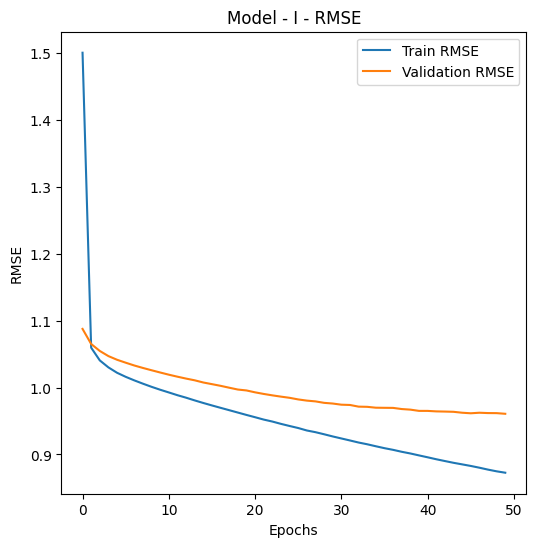

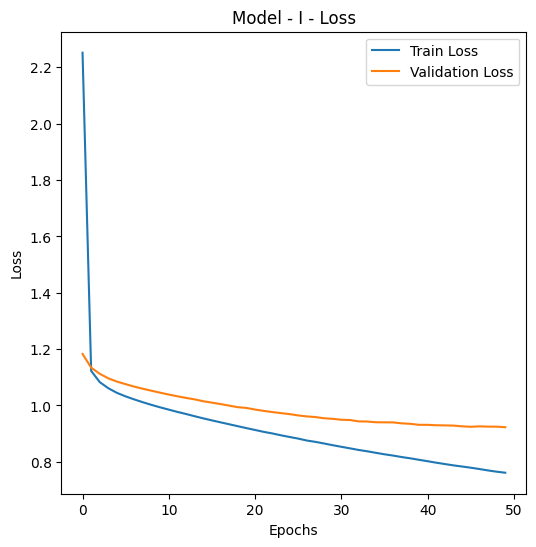

In [46]:
plot_training_results(train_losses, val_losses, train_rmse_values, val_rmse_values, "Model - I")

In [47]:
predict_rating(model_1, 123, 'American Pie')

Predicted rating for 'American Pie' (Movie ID 1046): 3.3792595863342285


In [48]:
top_movies = predict_movie(model_1, 123, top_n=10)

Predicting movies:   0%|          | 0/43188 [00:00<?, ?it/s]

Top 10 recommendations for user 123:

1. Bridesmaids
2. Keeping the Faith
3. The Million Dollar Hotel
4. Just the Ticket
5. Kissin' Cousins
6. Das Boot
7. Onna no mizûmi
8. Army of Darkness
9. Once Were Warriors
10. Buio Omega


In [49]:
metadata_df = get_movie_metadata(top_movies)

In [50]:
metadata_df

,original_title,genres,overview
1,Bridesmaids,"Comedy, Romance",Annie’s life is a mess. But when she finds out...
2,Keeping the Faith,Comedy,"Best friends since they were kids, Rabbi Jacob..."
3,The Million Dollar Hotel,"Drama, Thriller",The Million Dollar Hotel starts with a jump fr...
4,Just the Ticket,"Comedy, Romance",Gary Starke is one of the best ticket scalpers...
5,Kissin' Cousins,"Comedy, Music, Romance",An Army officer returns to the Smoky Mountains...
6,Das Boot,"Action, Drama, History, War, Adventure",A German submarine hunts allied ships during t...
7,Onna no mizûmi,Drama,A married woman lets her lover take naked pict...
8,Army of Darkness,"Fantasy, Horror, Comedy",A man is accidentally transported to 1300 A.D....
9,Once Were Warriors,Drama,A drama about a Maori family lving in Auckland...
10,Buio Omega,Horror,A young rich orphan loses his fiancée to voodo...


In [53]:
combined_df[combined_df["userId"] == 123].head(10)

,userId,movieId,rating,date,original_title,genres,overview,enhanced_emb
8066,123,0,3.0,2006-05-17 03:20:00,Ariel,"Drama, Crime",Taisto Kasurinen is a Finnish coal miner whose...,"[0.014193344861268997, -0.05715101957321167, -..."
8067,123,12,4.0,2006-05-17 03:20:27,Metropolis,"Drama, Science Fiction",In a futuristic city sharply divided between t...,"[-0.029966622591018677, -0.016698572784662247,..."
8068,123,66,5.0,2006-05-17 03:35:38,Trois couleurs : Rouge,"Drama, Mystery, Romance",Red This is the third film from the trilogy by...,"[-0.033099640160799026, -0.05097169429063797, ..."
8069,123,185,3.0,2006-05-17 03:23:57,Le Mépris,Drama,Screenwriter Paul Javal's marriage to his wife...,"[-0.024741562083363533, -0.04042617976665497, ..."
8070,123,206,4.5,2006-05-17 03:27:34,A River Runs Through It,Drama,A River Runs Through is a cinematographically ...,"[-0.03282554820179939, -0.03526582196354866, -..."
8071,123,208,3.0,2006-05-17 03:31:18,Terminator 3: Rise of the Machines,"Action, Thriller, Science Fiction",It's been 10 years since John Connor saved Ear...,"[-0.023339396342635155, 0.009901013225317001, ..."
8072,123,224,3.5,2006-05-17 03:27:00,The Million Dollar Hotel,"Drama, Thriller",The Million Dollar Hotel starts with a jump fr...,"[-0.030877070501446724, 0.006686699576675892, ..."
8073,123,250,4.0,2006-05-17 03:23:48,The Devil Wears Prada,"Comedy, Drama, Romance",The Devil Wears Prada is about a young journal...,"[0.028154615312814713, -0.03285352513194084, 0..."
8074,123,346,5.0,2006-05-17 03:29:50,Once Were Warriors,Drama,A drama about a Maori family lving in Auckland...,"[-0.017771631479263306, -0.061194270849227905,..."
8075,123,355,2.5,2006-05-17 03:40:48,The Man with the Golden Arm,"Crime, Drama, Romance",Frankie is a heroin addict and sits in prison....,"[-0.028563635423779488, 0.007999413646757603, ..."


### 3.2. Model 2

- Increased Embedding Dimension: Model 2 uses a larger embedding dimension (128), potentially allowing for more complex feature representation compared to Model 1.

- Adam Optimizer: Model 2 employs the Adam optimizer instead of SGD, which might improve convergence speed and performance due to its adaptive learning rate capabilities.

- Kaiming Initialization: Model 2 includes Kaiming (He) initialization for both linear and embedding layers, aiming to improve training stability, particularly with ReLU activations.

In [75]:
class MovieModel(nn.Module):
    def __init__(self, embedding_dim, num_users, num_movies, bert_embedding_dim):
        super(MovieModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.bert_embedding = nn.Linear(bert_embedding_dim, embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
        self._init_weights()

    def _init_weights(self):
        # Kaiming Initialization for Linear layers
        for layer in self.fc:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')

        # Optionally: Kaiming Initialization for Embedding layers
        init.kaiming_normal_(self.user_embedding.weight, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.movie_embedding.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, user_ids, movie_ids, bert_embeddings):
        user_embeds = self.user_embedding(user_ids)
        movie_embeds = self.movie_embedding(movie_ids)
        bert_embeds = self.bert_embedding(bert_embeddings)
        combined = torch.cat([user_embeds, movie_embeds, bert_embeds], dim=1)
        output = self.fc(combined)
        return output

### 3.2.1 Defining Optimizers, Loss Functions and Instantiating the model_2

In [76]:
# Initialize the model
embedding_dim = 64
num_users = len(user_encoder.classes_)  # Make sure you have defined user_encoder earlier
num_movies = len(movie_encoder.classes_)  # Make sure you have defined movie_encoder earlier
model_2 = MovieModel(embedding_dim, num_users=num_users, num_movies=num_movies, bert_embedding_dim=772)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)

### 3.2.2 Training Loop

Epoch [1/10] - Train Loss: 1.1013322523059814 - Train RMSE: 1.0494438409805298 - Validation Loss: 0.8701107011121862 - Validation RMSE: 0.9327972531318665
Epoch [2/10] - Train Loss: 0.7671954696998 - Train RMSE: 0.8758969306945801 - Validation Loss: 0.8635627083918628 - Validation RMSE: 0.9292807579040527
Epoch [3/10] - Train Loss: 0.6905051497252364 - Train RMSE: 0.8309664130210876 - Validation Loss: 0.8609298765659332 - Validation RMSE: 0.9278630614280701
Epoch [4/10] - Train Loss: 0.6232596625524917 - Train RMSE: 0.789467990398407 - Validation Loss: 0.8821846422027139 - Validation RMSE: 0.9392468333244324
Epoch [5/10] - Train Loss: 0.5406452832547458 - Train RMSE: 0.7352858781814575 - Validation Loss: 0.9070506937363568 - Validation RMSE: 0.9523921012878418
Epoch [6/10] - Train Loss: 0.45618846470882235 - Train RMSE: 0.6754172444343567 - Validation Loss: 0.9495048154802883 - Validation RMSE: 0.9744253754615784
Epoch [7/10] - Train Loss: 0.3717159136002393 - Train RMSE: 0.60968506336

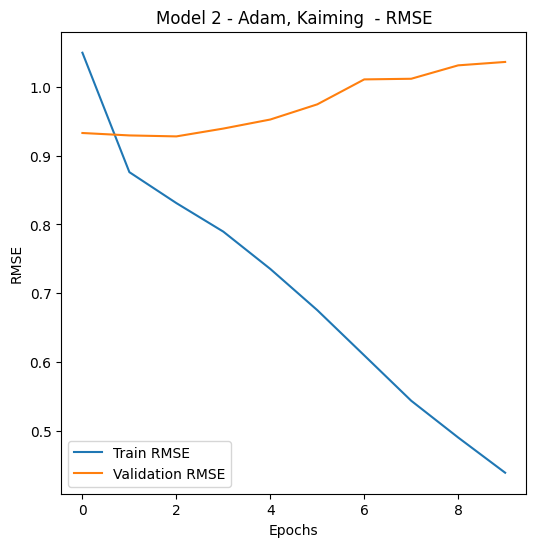

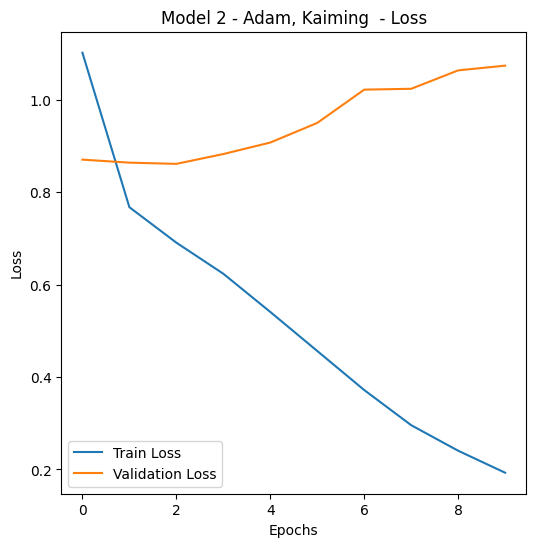

In [77]:
train_losses, val_losses, train_rmse_values, val_rmse_values = train_model(model_2, train_loader, val_loader, optimizer_2, criterion, num_epochs=10, model_num="model_2")

plot_training_results(train_losses, val_losses, train_rmse_values, val_rmse_values, "Model 2 - Adam, Kaiming ")


### Complete Over-fitting we can see Validation loss and RMSE have increased as epochs increase

### 3.3. Model - 3

- Additional Hidden Layer: Model 3 includes an extra hidden layer in the fully connected network, enhancing its ability to capture more complex patterns and relationships in the data.

- Dropout for Regularization: Dropout layers are introduced in the fully connected network, providing regularization to prevent overfitting by randomly dropping units during training.

- Increased Model Capacity: The first layer of the fully connected network has an increased number of neurons (512), offering greater model capacity to learn from the data.

- Weight Decay (L2 Regularization): The inclusion of weight decay in the optimizer acts as L2 regularization, penalizing large weights and further contributing to the reduction of overfitting risk.

### 3.2.1 Defining Model Class

In [78]:
class MovieModel(nn.Module):
    def __init__(self, embedding_dim, num_users, num_movies, bert_embedding_dim, dropout_rate):
        super(MovieModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.bert_embedding = nn.Linear(bert_embedding_dim, embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 3, 512),  # Increased first layer size
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),  # Additional hidden layer
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )
        self._init_weights()

    def _init_weights(self):
        # Kaiming Initialization for Linear layers
        for layer in self.fc:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')

        # Optionally: Kaiming Initialization for Embedding layers
        init.kaiming_normal_(self.user_embedding.weight, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.movie_embedding.weight, mode='fan_in', nonlinearity='relu')
    
    def forward(self, user_ids, movie_ids, bert_embeddings):
            user_embeds = self.user_embedding(user_ids)
            movie_embeds = self.movie_embedding(movie_ids)
            bert_embeds = self.bert_embedding(bert_embeddings)
            combined = torch.cat([user_embeds, movie_embeds, bert_embeds], dim=1)
            output = self.fc(combined)
            return output



### 3.3.2 Defining Optimizers, Loss Functions and Instantiating the model_3

In [83]:
# Initialize the modified Model 3
dropout_rate = 0.3
model_3 = MovieModel(embedding_dim=128, num_users=num_users, num_movies=num_movies, bert_embedding_dim=772, dropout_rate=dropout_rate)

# Optimizer with weight decay
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.001, weight_decay=0.01)

### 3.3.3 Training Loop

Epoch [1/10] - Train Loss: 1.1937956057096784 - Train RMSE: 1.0926095247268677 - Validation Loss: 0.9219028476406547 - Validation RMSE: 0.9601576924324036
Epoch [2/10] - Train Loss: 0.967152815655266 - Train RMSE: 0.9834392666816711 - Validation Loss: 0.8991338014602661 - Validation RMSE: 0.9482266902923584
Epoch [3/10] - Train Loss: 0.9172503934977086 - Train RMSE: 0.9577319025993347 - Validation Loss: 0.8438251965186175 - Validation RMSE: 0.9185996055603027
Epoch [4/10] - Train Loss: 0.9053040121829039 - Train RMSE: 0.951474666595459 - Validation Loss: 0.8730562601019355 - Validation RMSE: 0.9343748092651367
Epoch [5/10] - Train Loss: 0.8856958208703681 - Train RMSE: 0.9411141276359558 - Validation Loss: 0.8362254141008153 - Validation RMSE: 0.9144536256790161
Epoch [6/10] - Train Loss: 0.8745023040100932 - Train RMSE: 0.935148298740387 - Validation Loss: 0.8521622594665078 - Validation RMSE: 0.9231263399124146
Epoch [7/10] - Train Loss: 0.8638869233331398 - Train RMSE: 0.92945522069

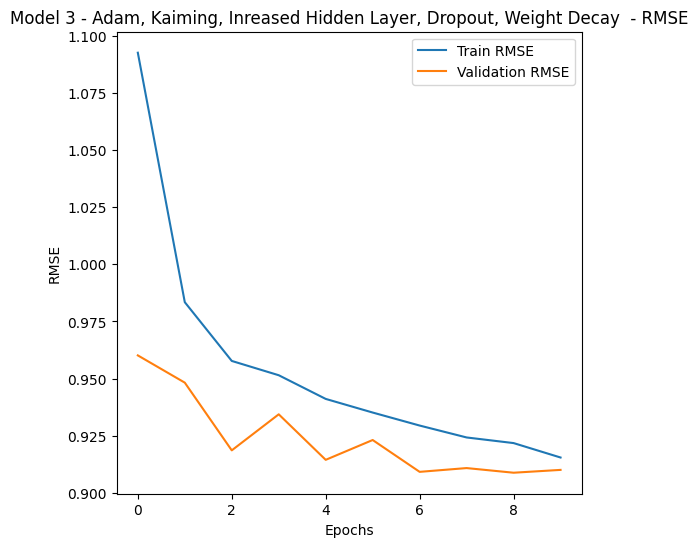

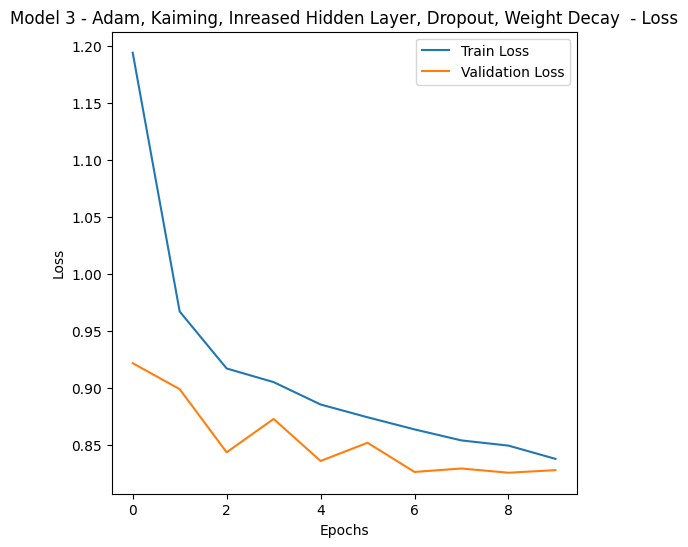

In [84]:
train_losses, val_losses, train_rmse_values, val_rmse_values = train_model(model_3, train_loader, val_loader, optimizer_3, criterion, num_epochs=10, model_num="model_3")

plot_training_results(train_losses, val_losses, train_rmse_values, val_rmse_values, "Model 3 - Adam, Kaiming, Inreased Hidden Layer, Dropout, Weight Decay ")


## Part 4  - Final Run Combine Results
---

In [ ]:
combined_train_val_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
combined_train_val_loader = torch.utils.data.DataLoader(combined_train_val_dataset, batch_size=64, shuffle=True)

# Initialize the modified Model 3
dropout_rate = 0.3
model_3 = MovieModel(embedding_dim=128, num_users=num_users, num_movies=num_movies, bert_embedding_dim=772, dropout_rate=dropout_rate)

# Optimizer with weight decay
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.001, weight_decay=0.01)

### 4.2. Training Loop!

In [ ]:
train_losses, val_losses, train_rmse_values, val_rmse_values = train_model(model_3, combined_train_val_loader, optimizer_3, criterion, num_epochs=10, model_num="Final_Model_Full")

plot_training_results(train_losses, val_losses, train_rmse_values, val_rmse_values, "Final Model Full")
